In [28]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [58]:
import pandas as pd
import json

import matplotlib.pyplot as plt
from matplotlib import cm

<IPython.core.display.Javascript object>

In [6]:
def read_face_data_record(record: dict) -> dict:
    return {
        "is_face_detected": record["is_face_detected"],
        "angry": record["emotions"]["angry"],
        "disgust": record["emotions"]["disgust"],
        "fear": record["emotions"]["fear"],
        "happy": record["emotions"]["happy"],
        "sad": record["emotions"]["sad"],
        "neutral": record["emotions"]["neutral"],
        "head_turn": record["head_turn"],
        "eyes_closed": record["eyes_closed"],
    }

In [7]:
def get_signal_df_list(data_files: list) -> list:
    face_data_signals = []
    for data_file in data_files:
        with open(data_file) as f:
            face_data = pd.DataFrame(
                [read_face_data_record(json.loads(line)) for line in f]
            )
        face_data_signals.append(face_data)
    return face_data_signals

In [9]:
def merge_on_metric(
    face_data_signals: list,
    attr_name: str,
    column_names: list,
    smoothing_window: int,
    min_len: int,
) -> pd.DataFrame:
    res_df = (
        pd.DataFrame(
            [face_data[attr_name][:min_len] for face_data in face_data_signals],
        )
        .T.ewm(span=smoothing_window)
        .mean()
    )
    res_df.columns = column_names
    return res_df

In [11]:
min_len = min([face_data_signal.shape[0] for face_data_signal in face_data_signals])
min_len

3758

In [93]:
eyeblink_trashold = 2.5

<IPython.core.display.Javascript object>

In [94]:
data_files = [
    "uhmm_video_1.json",
    "uhmm_video_2.json",
    "uhmm_video_3.json",
    "uhmm_video_4.json",
    "face_data.json",
    "face_data2.json",
    "french_lesson.json",
    "fake_happy1.json",
    "fake_happy2.json",
    "fake_happy3.json",
]
# data_files = ["fake_happy1.json", "fake_happy2.json", "fake_happy3.json"]
face_data_signals = get_signal_df_list(data_files)

<IPython.core.display.Javascript object>

In [95]:
eye_blink_df = merge_on_metric(
    face_data_signals=face_data_signals,
    attr_name="eyes_closed",
    column_names=data_files,
    smoothing_window=1,
    min_len=min_len,
)
eye_blink_df.head()

,uhmm_video_1.json,uhmm_video_2.json,uhmm_video_3.json,uhmm_video_4.json,face_data.json,face_data2.json,french_lesson.json,fake_happy1.json,fake_happy2.json,fake_happy3.json
0,1.887442,1.873390,1.770862,2.299422,1.921881,1.923602,1.803908,2.048678,1.956155,2.180537
1,1.755186,2.055892,2.017587,2.174038,1.846169,1.525109,1.950497,2.044005,2.095823,2.182409
2,1.761789,2.103807,1.923946,2.191412,2.172493,1.946306,1.836789,2.004816,2.794762,2.675545
3,1.793831,1.733494,2.045365,2.087144,2.342909,2.208209,1.944947,2.440553,3.701865,2.480786
4,1.827751,1.903533,1.776010,1.700293,2.218430,2.425398,1.939682,3.104736,4.005730,2.694943


<IPython.core.display.Javascript object>

In [96]:
eye_blink_df.describe()

,uhmm_video_1.json,uhmm_video_2.json,uhmm_video_3.json,uhmm_video_4.json,face_data.json,face_data2.json,french_lesson.json,fake_happy1.json,fake_happy2.json,fake_happy3.json
count,3758.000000,3758.000000,3758.000000,3758.000000,3758.000000,3758.000000,3758.000000,3758.000000,3758.000000,3758.000000
mean,1.834569,1.850816,1.808021,1.790455,2.172519,2.075468,2.062228,2.338166,2.322113,4.366045
std,0.486281,0.391244,0.442260,0.357910,0.886624,0.491659,0.640843,0.971744,0.838789,0.979687
min,0.525584,0.555399,0.537465,0.448276,0.763564,0.271645,0.809179,1.480005,1.363646,1.378999
25%,1.678777,1.695890,1.626697,1.600522,1.813930,1.860658,1.849783,2.143037,2.108435,4.756585
50%,1.833839,1.816725,1.747493,1.764913,2.025435,2.063010,2.031400,2.143037,2.108435,4.756585
75%,1.984713,1.946221,1.891826,1.959889,2.317557,2.237683,2.193797,2.143037,2.108435,4.756585
max,21.122777,15.013371,6.389741,5.584036,25.613460,9.871633,17.266297,25.923290,17.905040,13.265874


<IPython.core.display.Javascript object>

In [97]:
eyeblink_distances = [
    pd.Series(eye_blink_df.index[eye_blink_df[column] > eyeblink_trashold])
    .diff()
    .fillna(0)
    for column in data_files
]

<IPython.core.display.Javascript object>

In [98]:
mean_std_df = pd.DataFrame(
    [
        (eyeblink_distance.mean(), eyeblink_distance.std())
        for eyeblink_distance in eyeblink_distances
    ],
    columns=["mean", "std"],
    index=data_files,
)
mean_std_df

,mean,std
uhmm_video_1.json,41.440476,71.882828
uhmm_video_2.json,41.523810,84.029610
uhmm_video_3.json,23.980519,62.820365
uhmm_video_4.json,33.581818,74.863470
face_data.json,6.578947,20.525133
face_data2.json,11.869565,47.933536
french_lesson.json,20.638889,30.339193
fake_happy1.json,1.817967,4.157157
fake_happy2.json,1.635438,3.386571
fake_happy3.json,1.116231,1.430681


<IPython.core.display.Javascript object>

In [99]:
# mean_std_df.plot(x="mean", y="std", kind="scatter")

<IPython.core.display.Javascript object>

/var/folders/sh/7hxrl8k913x6_bnwkr3k_m880000gn/T/ipykernel_59483/2500347495.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap("Spectral")


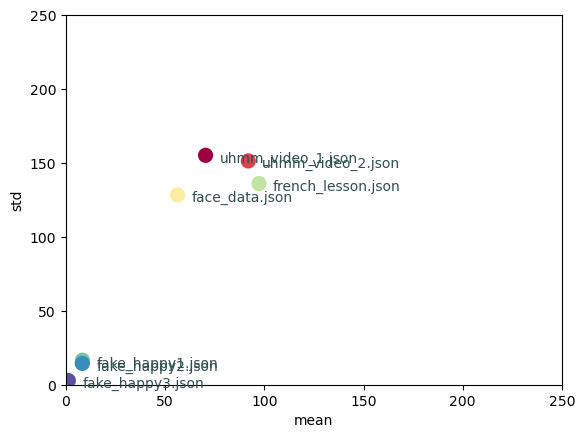

<IPython.core.display.Javascript object>

In [92]:
fig, ax = plt.subplots()
ax.set_xlim([0, 250])
ax.set_ylim([0, 250])

cmap = cm.get_cmap("Spectral")
mean_std_df.plot(
    "mean",
    "std",
    kind="scatter",
    ax=ax,
    s=120,
    linewidth=0,
    c=range(len(mean_std_df)),
    colormap=cmap,
)

for k, v in mean_std_df.iterrows():
    ax.annotate(
        k,
        v,
        xytext=(10, -5),
        textcoords="offset points",
        family="sans-serif",
        fontsize=10,
        color="darkslategrey",
    )